# Récupération des données à traiter

In [1]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sys
import os
import itertools
import shap
import pickle

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import StratifiedShuffleSplit
from joblib import dump, load


import xgboost as xgb

sys.stdout.flush()

def dumpModel(model, filename ):
    dump(model, '../models/' + filename)

def loadModel(filename):
    return load('../models/' + filename)

def modelAlreadyTrain(filename):
    return os.path.isfile(filename)

def savePickleModel(model, filename):
    with open('../models/' + filename, 'wb') as f:
        pickle.dump(model, f)
        f.close()

def loadPickleModel(filename):
    with open('../models/' + filename, 'rb') as f:
        model = pickle.load(f)
        f.close()
        return model

On travaille sur un serveur multiprocesseur.
> Nombre de processeurs utilisés :

In [2]:
import os

# Obtenir le nombre de cœurs logiques
num_logical_cores = os.cpu_count()
print(f"Nombre de cœurs logiques : {num_logical_cores}")

Nombre de cœurs logiques : 48


### Création des jeux de données d'entrainement et des jeux de données de test

In [3]:

df=pd.read_csv('../Data/processed/Co2_final.csv')

In [4]:
def calcTarget(X):
    if X <= 100 :
        return 1
    elif X > 100 and X <= 120:
        return 2
    elif X > 120 and X <= 140:
        return 3
    elif X > 140 and X <= 160:
        return 4
    elif X > 160 and X <= 200:
        return 5
    elif X > 200 and X <= 250:
        return 6
    elif X > 250 :
        return 7


df['target'] = df['Ewltp (g/km)'].apply(lambda x : calcTarget(x))

print(df.head())

         ID        Mp         T  m (kg)  Ewltp (g/km)  W (mm)  At1 (mm)  \
0  77074142  0.148938  0.003688   993.0         117.0  2492.0    1455.0   
1  77074143  0.148938  0.003688   993.0         117.0  2492.0    1455.0   
2  77074144  0.148938  0.003688   993.0         117.0  2492.0    1455.0   
3  77074145  0.148938  0.003688   993.0         117.0  2492.0    1455.0   
4  77074146  0.148938  0.003688   993.0         117.0  2492.0    1455.0   

   ec (cm3)  ep (KW)  Fuel consumption   ...  Ft_e85  Ft_lpg  Ft_ng  \
0     999.0     48.0                5.2  ...   False   False  False   
1     999.0     48.0                5.2  ...   False   False  False   
2     999.0     48.0                5.2  ...   False   False  False   
3     999.0     48.0                5.2  ...   False   False  False   
4     999.0     48.0                5.2  ...   False   False  False   

   Ft_petrol  Ft_petrol/electric   Fm_F   Fm_H  Fm_M   Fm_P  target  
0       True               False  False  False  True

In [5]:
X = df.drop(columns=['Ewltp (g/km)', 'ID', 'target'])
y = df['target']-1
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

> Mise à l'echelle des différentes valeurs

In [6]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


### Test sur un modele XGBClassifier

In [7]:
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold
import xgboost as xgb
import pandas as pd
import os

# Obtenir le nombre de cœurs logiques
num_logical_cores = os.cpu_count()
print(f"Nombre de cœurs logiques : {num_logical_cores}")

def EvaluateModelXGBClassifier(X, y, sample_size=500_000):
    # Stratifier les données en fonction des classes de y
    if X.shape[0] > sample_size:
        X, _, y, _ = train_test_split(X, y, train_size=sample_size, random_state=42, stratify=y)
        print(f"Dataset réduit à {sample_size} lignes pour l'entraînement.")

    # Définir la grille de paramètres = Paramètres pour GridSearch
    param_grid = {
        'n_estimators': [50, 100, 450, 500],
        'learning_rate': [0.01, 0.1, 0.3, 1],
        'objective': ['binary:logistic', 'multi:softprob'],
        'max_depth': [3,  7],       
        'min_child_weight': [1,  5],
        'subsample': [0.6,  1.0],
        'colsample_bytree': [0.6,  1.0], 
        'num_class': [len(set(y))]
    }

    # Configurer la validation croisée
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    
    model = xgb.XGBClassifier(learning_rate=0.1, random_state=42)
    # Début du chronométrage
    start_time = time.time()

    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=skf, scoring='accuracy', verbose=1, n_jobs=-1)
    grid_search.fit(X, y)

    # Fin du chronométrage
    end_time = time.time()
    # Calcul du temps écoulé
    elapsed_time = end_time - start_time
    print(f"Temps d'exécution pour déterminer les meilleurs parametres : {elapsed_time} secondes")


#        print("dataframe :\n", df_grd[['params', 'mean_test_score', 'std_test_score']])
    print("best score sur le train  : ", grid_search.best_score_)
    print("best param sur le train :", grid_search.best_params_)
    slct_mdl = grid_search.best_estimator_
    print("slct_mdl.score sur le test :", slct_mdl.score(X_test, y_test))

    print(f"Meilleur n_estimators: {grid_search.best_params_['n_estimators']}")
    print(f"Meilleure précision CV: {grid_search.best_score_:.4f}")

    return grid_search

EvaluateTrainingModelGrid = EvaluateModelXGBClassifier(X_train, y_train)

# Nombre de cœurs logiques : 48
# Dataset réduit à 500000 lignes pour l'entraînement.
# Fitting 3 folds for each of 512 candidates, totalling 1536 fits
# A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
# Temps d'exécution pour déterminer les meilleurs parametres : 11181.730349779129 secondes
# best score sur le train  :  0.9864959991438903
# best param sur le train : {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 500, 'num_class': 7, 'objective': 'binary:logistic', 'subsample': 1.0}
# slct_mdl.score sur le test : 0.9864238779692408
# Meilleur n_estimators: 500
# Meilleure précision CV: 0.9865

Nombre de cœurs logiques : 48
Dataset réduit à 500000 lignes pour l'entraînement.
Fitting 3 folds for each of 512 candidates, totalling 1536 fits


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Temps d'exécution pour déterminer les meilleurs parametres : 11181.730349779129 secondes
best score sur le train  :  0.9864959991438903
best param sur le train : {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 500, 'num_class': 7, 'objective': 'binary:logistic', 'subsample': 1.0}
slct_mdl.score sur le test : 0.9864238779692408
Meilleur n_estimators: 500
Meilleure précision CV: 0.9865


In [8]:
if modelAlreadyTrain('XGBoostClassifier.pkl'):
    model = loadPickleModel('XGBoostClassifier.pkl')
else :

    model=xgb.XGBClassifier(*EvaluateTrainingModelGrid.best_params_)
    
    params = model.get_params()
    print(model.get_params())
    # Début du chronométrage
    start_time = time.time()
    model.fit(X_train, y_train)
    # Fin du chronométrage
    end_time = time.time()
    # Calcul du temps écoulé
    elapsed_time = end_time - start_time
    print(f"Temps d'exécution de l'entrainement : {elapsed_time} secondes")
    savePickleModel(model,'XGBoostClassifier.pkl')
    # Temps d'exécution de l'entrainement : 30.832000494003296 secondes

{'objective': 'colsample_bytree', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': None, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': None, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None, 'kwargs': 'learning_rate'}


Pass `objective` as keyword args.


Temps d'exécution de l'entrainement : 30.240554332733154 secondes


> Affichage des métriques RMSE et R²

In [9]:
from ClassificationModel import ClassificationModel
XGBModel = ClassificationModel('XGBClassifier',
                               model, 
                               X_train, 
                               X_test, 
                               y_train, 
                               y_test, 
                               X.columns)
 # Début du chronométrage
start_time = time.time()
XGBModel.predictModel()
    # Fin du chronométrage
end_time = time.time()
    # Calcul du temps écoulé
elapsed_time = end_time - start_time
print(f"Temps d'exécution pour fitter sur le meilleur modèle: {elapsed_time} secondes")

XGBModel.calcScore()
XGBModel.displayScore()



<class 'xgboost.sklearn.XGBClassifier'>
Temps d'exécution pour fitter sur le meilleur modèle: 4.970858812332153 secondes
RMSE Jeux d entrainement : 0.11548185177220063
RMSE Jeux de test : 0.11616039012114984
Score du modèle train (R²) 0.9866671573131816
Score du modèle test (R²) 0.9865367741419176
Classification Report :
              precision    recall  f1-score   support

           A       1.00      1.00      1.00    109882
           B       0.98      0.98      0.98    134814
           C       0.99      0.98      0.99    242103
           D       0.98      0.99      0.99    118751
           E       0.99      0.99      0.99     62022
           F       0.98      0.98      0.98     24560
           G       0.97      0.96      0.96      7626

    accuracy                           0.99    699758
   macro avg       0.98      0.98      0.98    699758
weighted avg       0.99      0.99      0.99    699758



> Affichage de la matrice de confusion permettant de vérifier les performances du modèle

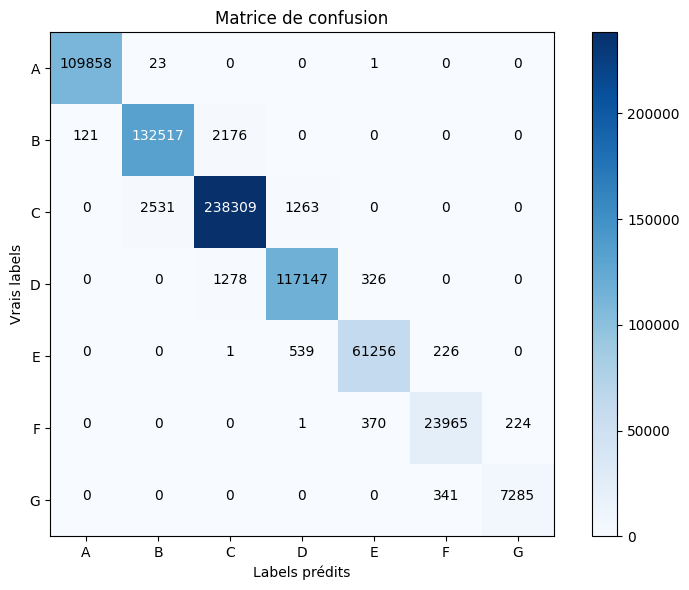

In [10]:
XGBModel.displayConfusionMatrix()

In [11]:
XGBModel.writeResults()

> Affichage du rapport de classification

> Affichage de l'importance des features dans la prédiction du modèle en pourcentage 

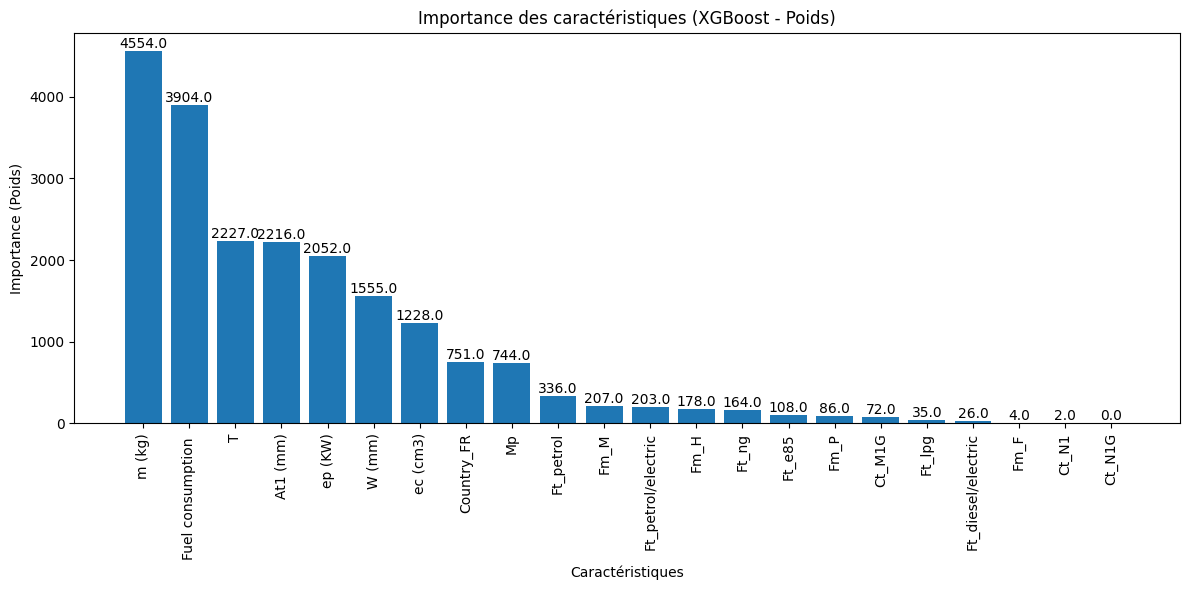

In [12]:
XGBModel.displayFeatureImportances()

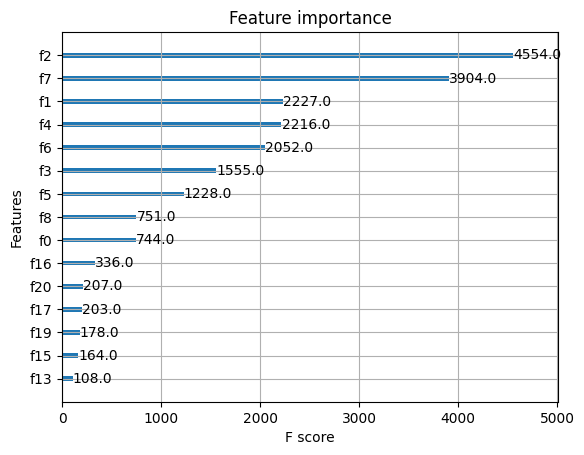

In [13]:
xgb.plot_importance(model, max_num_features=15);

> Affichage du rapport de classification

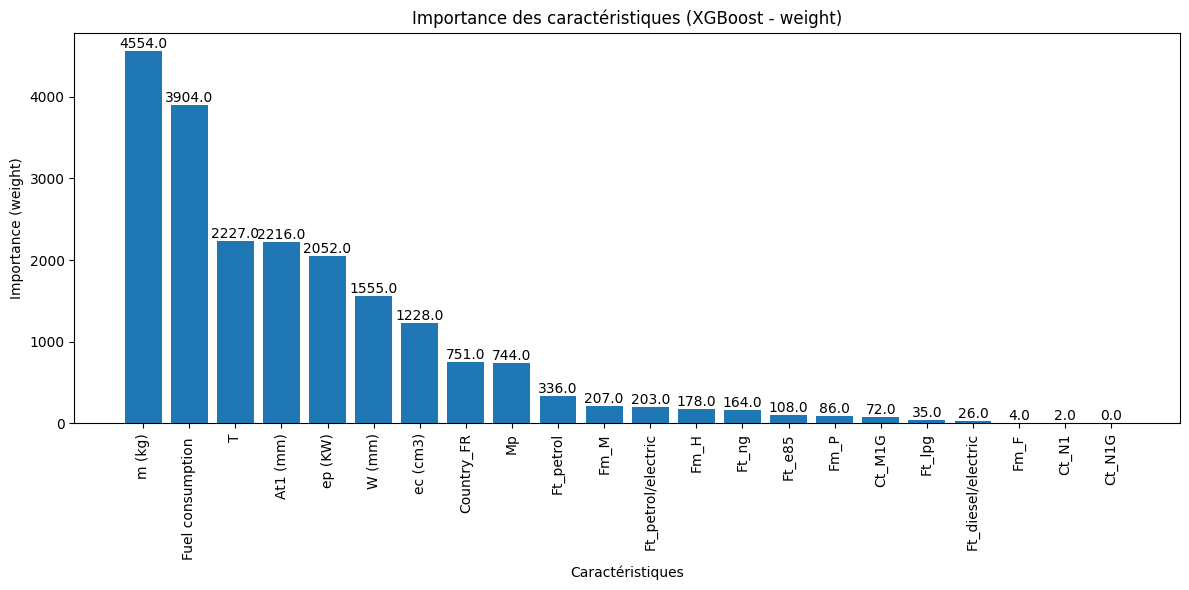

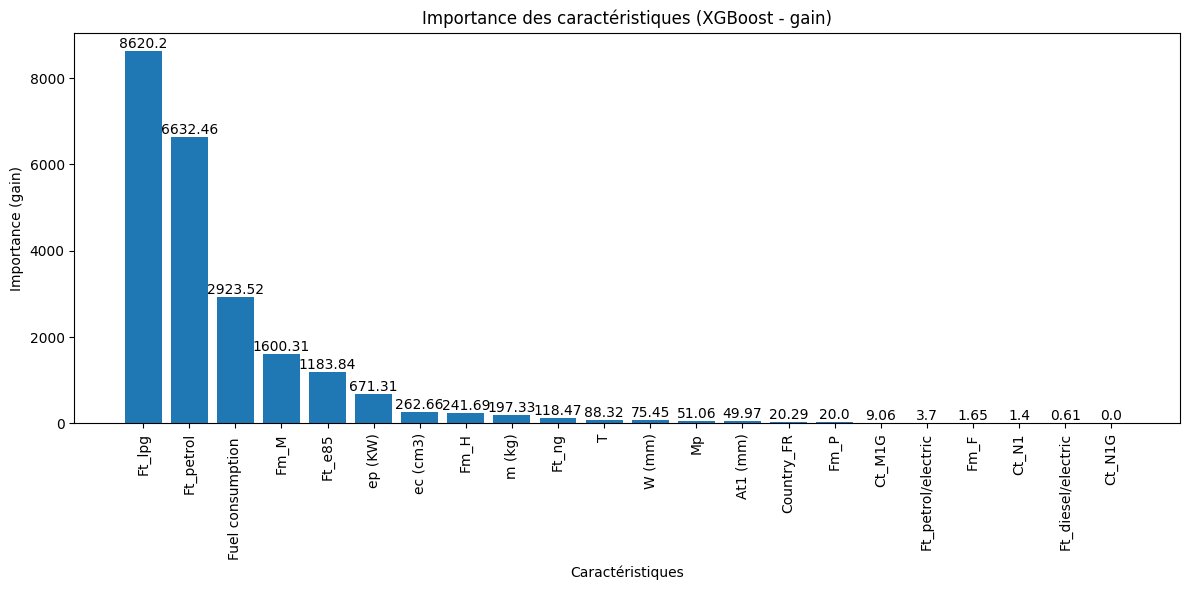

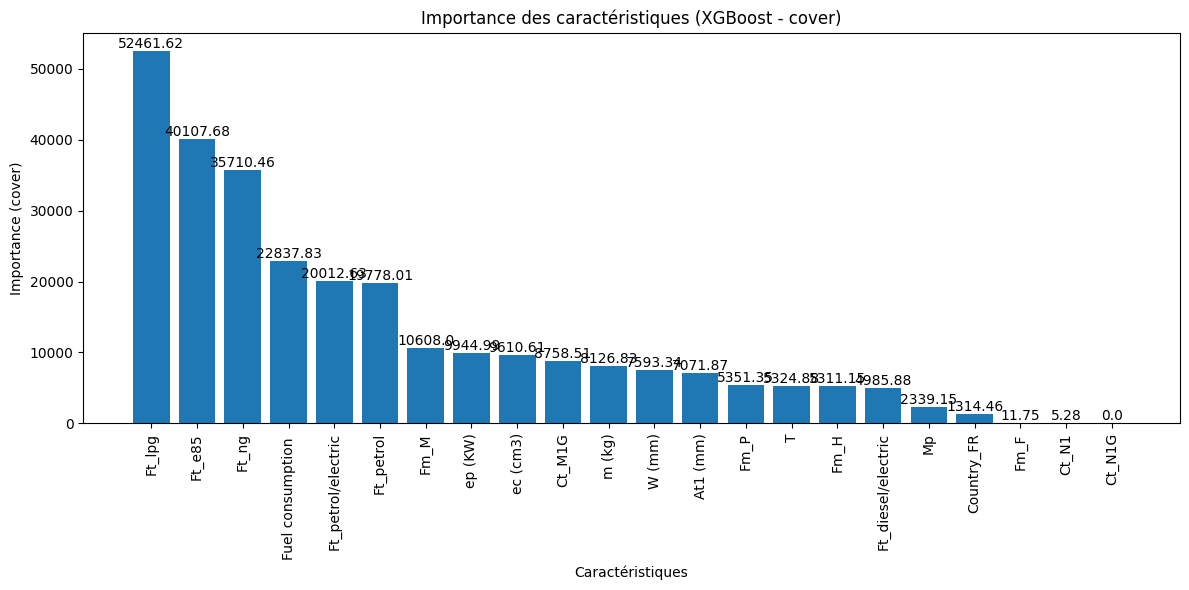

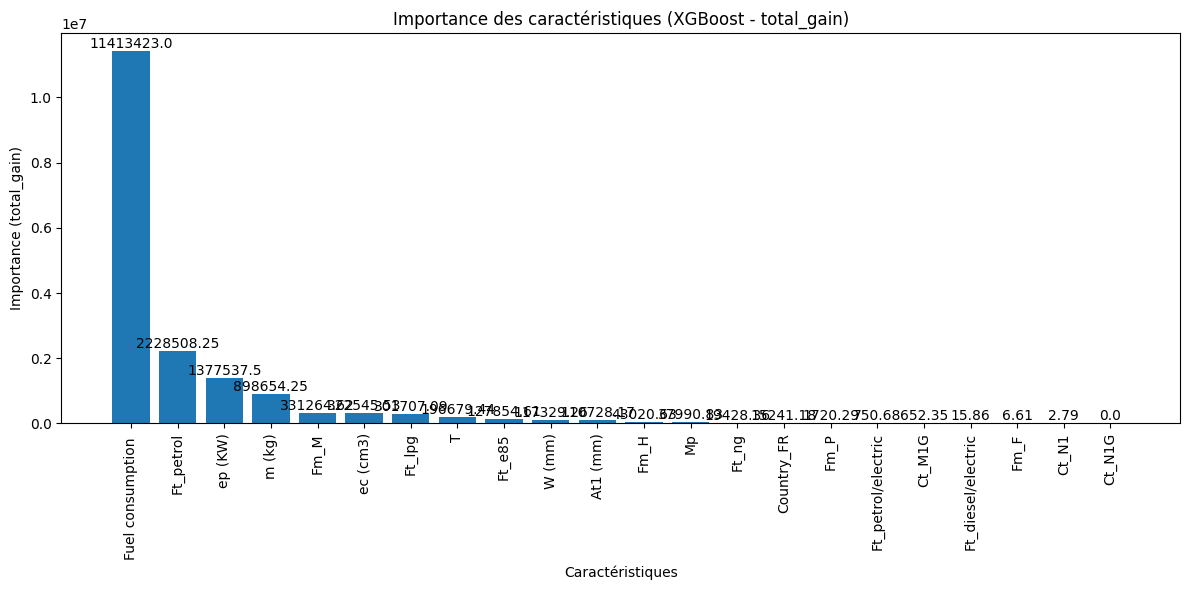

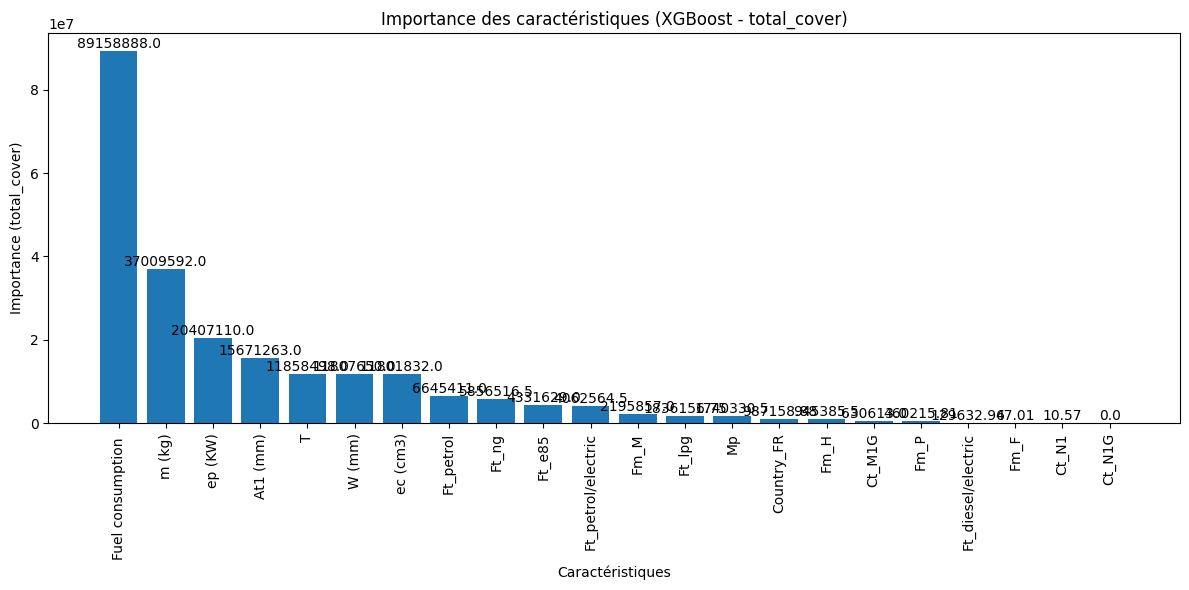

In [14]:
def displayFeatureImportancesXGB(model,columns,importance_type):
    booster = model.get_booster()
    importance_dict = booster.get_score(importance_type=importance_type)
            
    # Initialisation des importances avec zéro
    feature_importances = np.zeros(len(columns))
            
    # Mapping des indices aux colonnes via columns
    for feature, score in importance_dict.items():
        if feature.startswith('f'):
            index = int(feature[1:])  # Extrait l'indice de 'f0', 'f1', etc.
            feature_importances[index] = score
    
            # Tri décroissant des importances
    indices = np.argsort(feature_importances)[::-1]
            
            # Plot
    plt.figure(figsize=(12, 6))
    plt.title(f"Importance des caractéristiques (XGBoost - {importance_type})")
    bars = plt.bar(range(len(columns)), feature_importances[indices], align="center")
    plt.xticks(range(len(columns)), columns[indices], rotation=90)
    plt.xlabel("Caractéristiques")
    plt.ylabel(f"Importance ({importance_type})")
    # Affichage des valeurs sur les barres
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha="center", va="bottom")
    plt.tight_layout()
    plt.show()

types= ['weight', 'gain', 'cover', 'total_gain', 'total_cover']

for importance_type in types:
    displayFeatureImportancesXGB(model,X.columns,importance_type)


Utilisation de Shap

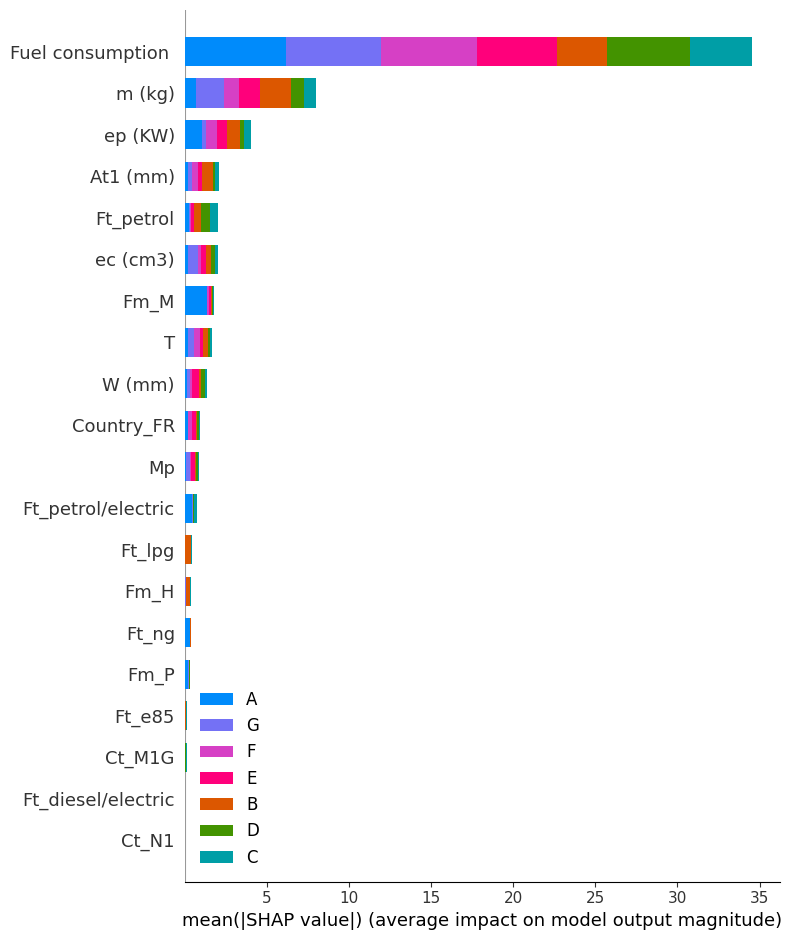

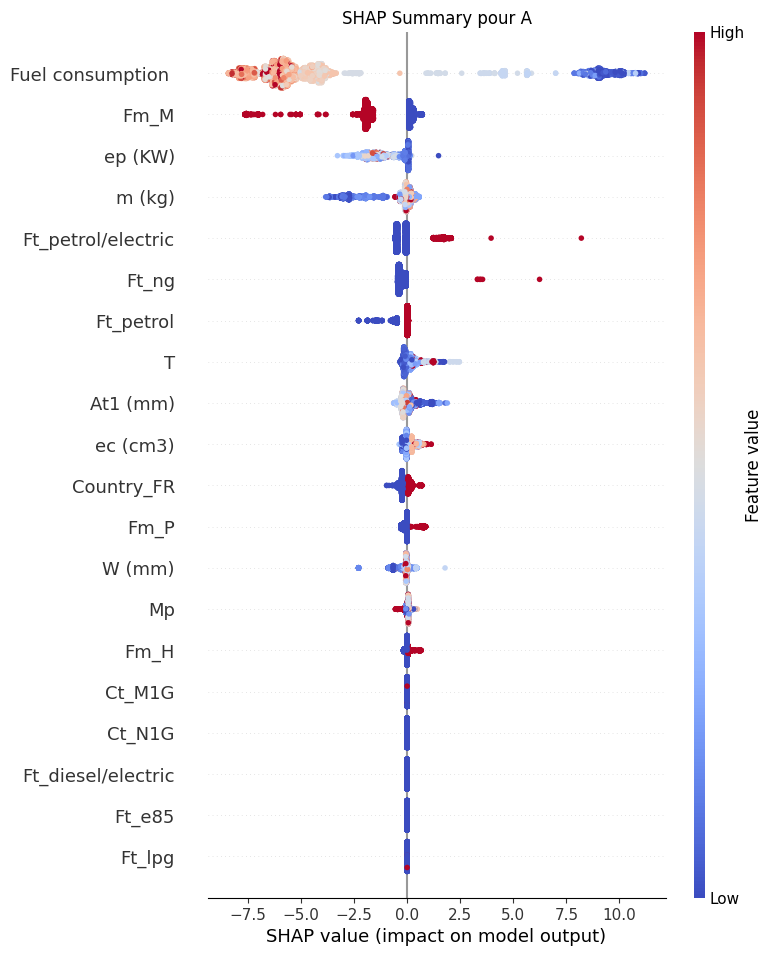

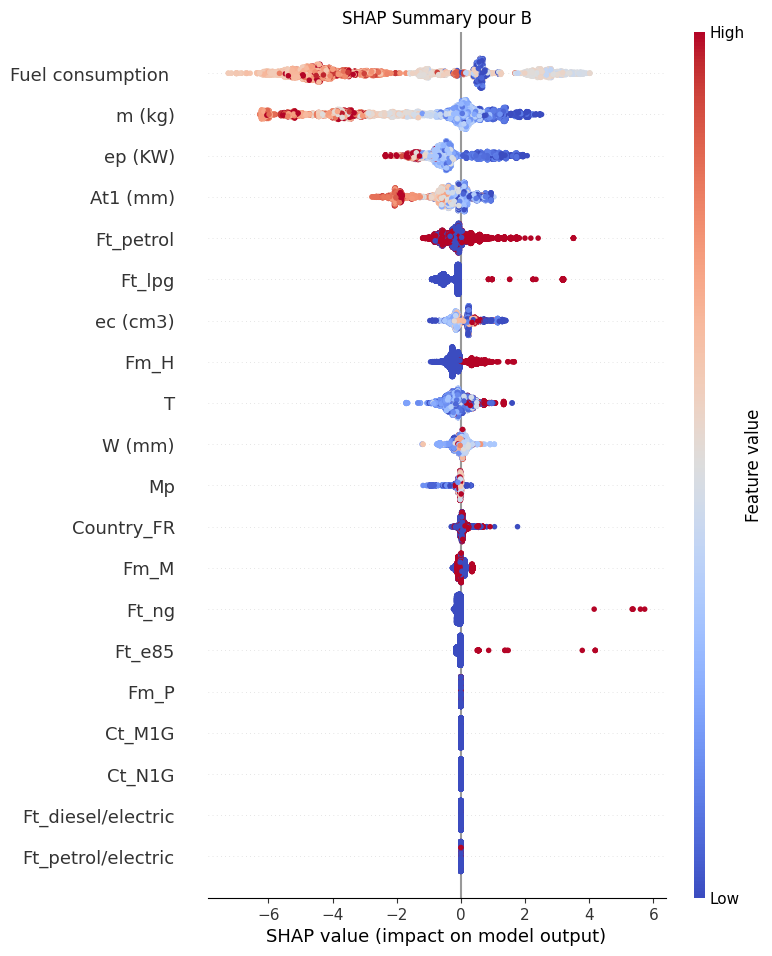

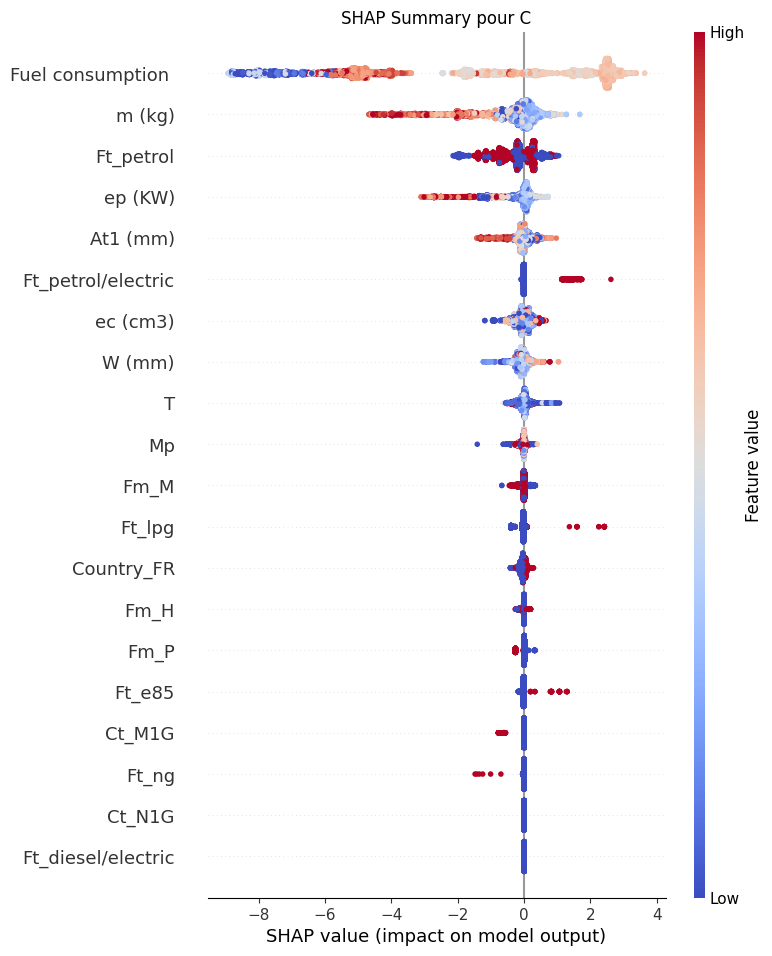

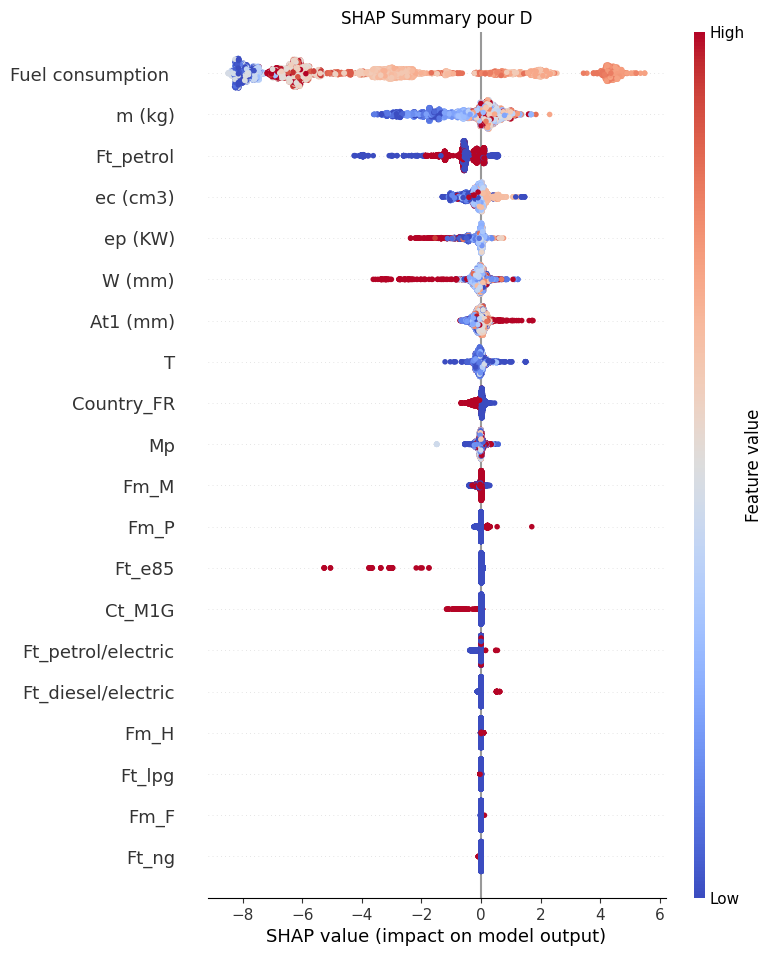

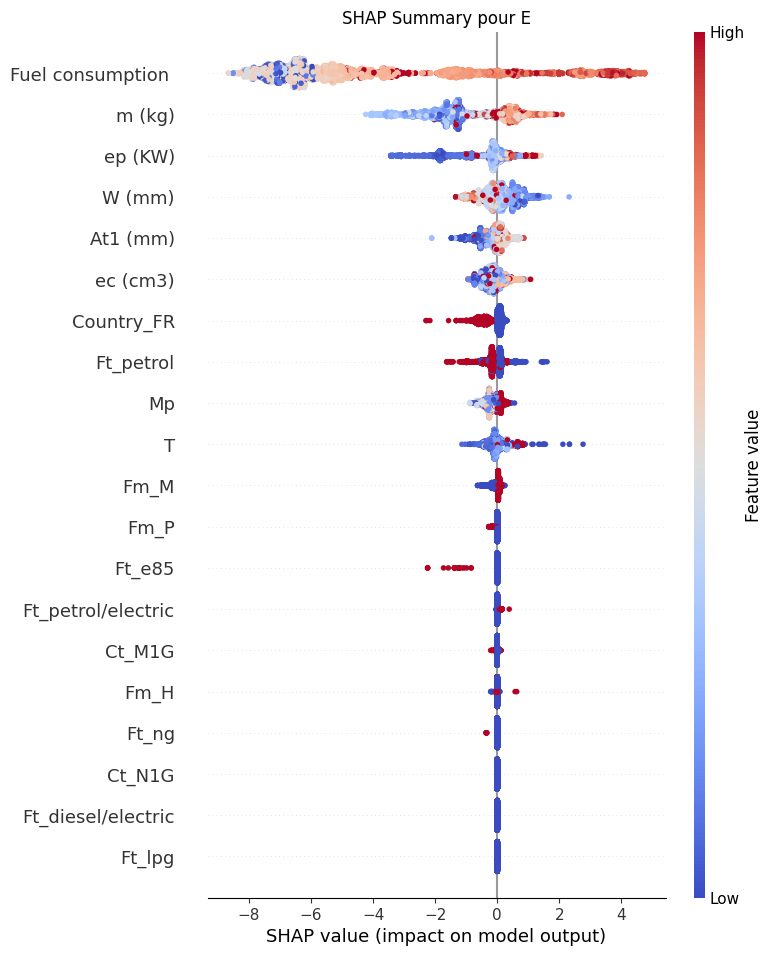

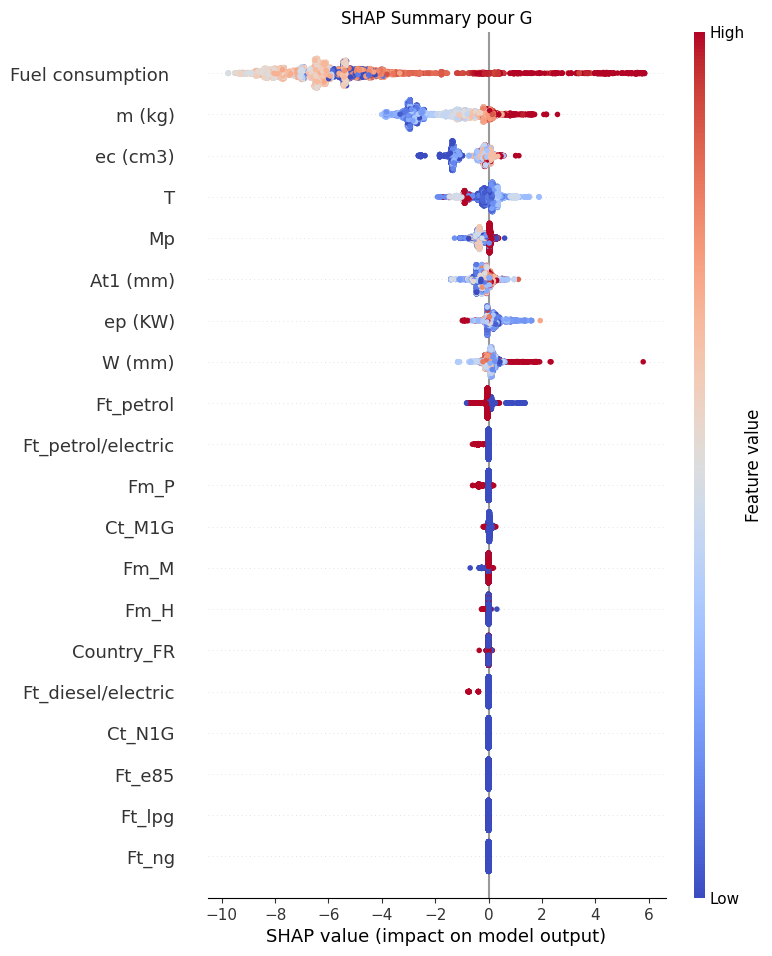

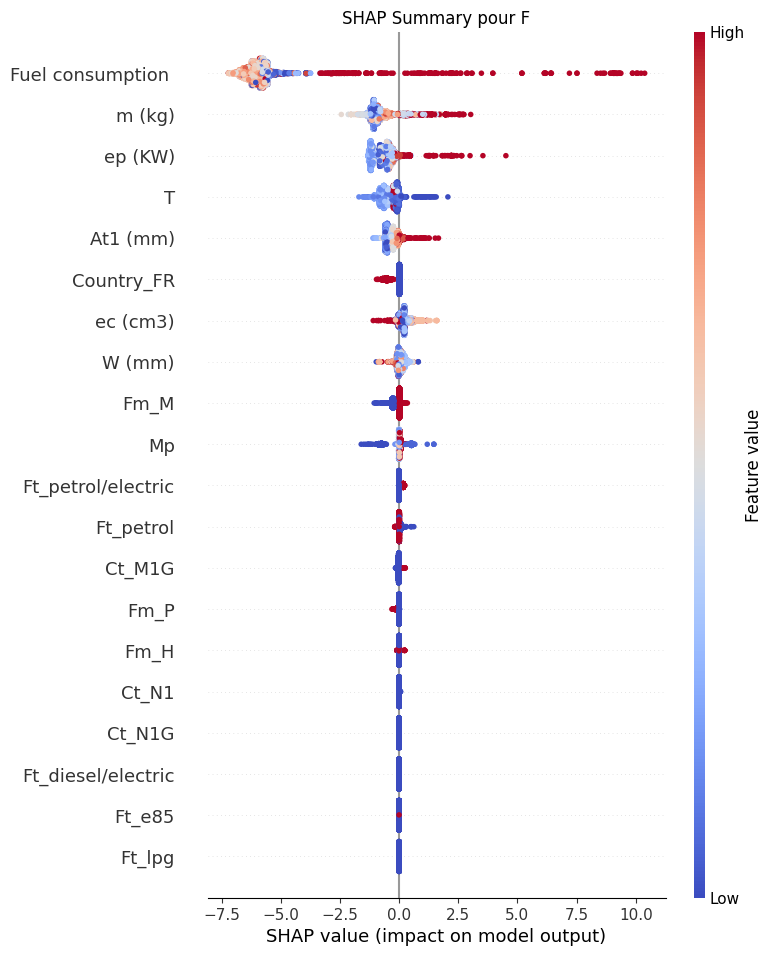

Temps d'exécution pour réaliser le shap: 11.456353902816772 secondes


In [15]:
# Début du chronométrage
start_time = time.time()
XGBModel.displayShap(5000)
end_time = time.time()
    # Calcul du temps écoulé
elapsed_time = end_time - start_time
print(f"Temps d'exécution pour réaliser le shap: {elapsed_time} secondes")